In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json
from pandas.io.json import json_normalize

%matplotlib inline

init_notebook_mode(connected=True)

In [3]:
def str_to_list(x):
    return eval(x) if x and x != '#N/A' else []

list_cols = [
    'genres',
    'belongs_to_collection',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'Keywords',
    'cast',
    'crew'
]


## set io_params to unfold the JSON-like string to lists
io_params = {
    'index_col': 'id',
    'converters': {col: str_to_list for col in list_cols}
}

# We can read the train and the test in one go using the concat function
# data = pd.read_csv('../data/train.csv', **io_params)
data = pd.concat(
    objs=(
        pd.read_csv('/Users/shenghaoxu/Desktop/DS_Projects/kaggle_box_office/box_office_pred/data/train.csv', **io_params).assign(is_train=True),
        pd.read_csv('/Users/shenghaoxu/Desktop/DS_Projects/kaggle_box_office/box_office_pred/data/test.csv', **io_params).assign(is_train=False)
    ),
    sort=False
)


In [4]:
train_eda_data = data[data['is_train'] == True] 

## EDA and Feature Engineering

In [5]:
## budget:
budget_plot_data = [go.Scatter(x=train_eda_data['budget'], y=train_eda_data['revenue'], mode='markers')]
layout = go.Layout(
    xaxis=dict(
        range=[0, 1e8]
    ),
    yaxis=dict(
        range=[0, 1e9]
    )
)
iplot(go.Figure(data = budget_plot_data))

['Mystery', 'Romance', 'History', 'Family', 'Fantasy', 'Horror', 'Crime', 'Drama', 'Science Fiction', 'Animation', 'Music', 'Adventure', 'Foreign', 'Action', 'TV Movie', 'Comedy', 'Documentary', 'War', 'Thriller', 'Western']
Mystery
Romance
History
Family
Fantasy
Horror
Crime
Drama
Science Fiction
Animation
Music
Adventure
Foreign
Action
TV Movie
Comedy
Documentary
War
Thriller
Western
Mystery
Romance
History
Family
Fantasy
Horror
Crime
Drama
Science Fiction
Animation
Music
Adventure
Foreign
Action
TV Movie
Comedy
Documentary
War
Thriller
Western


Text(0,0.5,'Average Revenues')

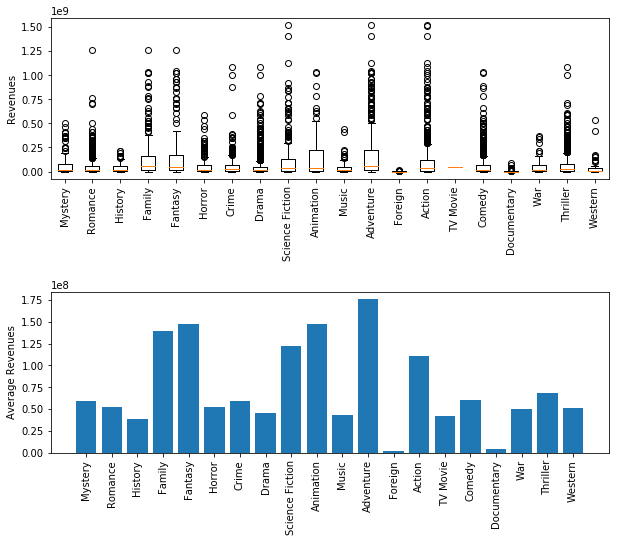

In [6]:
## genres: one hot encoding
def check_values(column, key, value):
    """
    input: 
    output: a vector of True/False
    """
    results = []
    for list_of_dict in column:
        value_found = False
        for item in list_of_dict:
            if item[key] == value:
                value_found = True
        results.append(value_found)
    return results
    
def get_freqs(series, attribute):
    freq_dict = {}
    for values_list in series:
        for values_dict in values_list:
            if values_dict[attribute] not in freq_dict:
                freq_dict[values_dict[attribute]] = 1
            else:
                freq_dict[values_dict[attribute]] += 1
    return freq_dict

genre_freq = get_freqs(data['genres'], 'name')
unique_genres = genre_freq.keys()

print(unique_genres)

## One-Hot Encoding:
for genre_name in unique_genres:
    data[genre_name] = np.where(check_values(data['genres'], 'name', genre_name), 1, 0)

data_to_plot = []
for genre_name in unique_genres:
    print(genre_name)
    data_to_plot.append(data[data[genre_name] == 1 & data['is_train']]['revenue'].dropna().values)

fig = plt.figure(1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Create an axes instance
ax = fig.add_subplot(211)

# Create the boxplot
ax.boxplot(data_to_plot)
ax.set_xticklabels(unique_genres)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Revenues')

    
averages = []
for genre_name in unique_genres:
    print(genre_name)
    averages.append(data[data[genre_name] == 1 & data['is_train']]['revenue'].dropna().values.mean())

genre_barplot = fig.add_subplot(212)
genre_barplot.bar(unique_genres, averages)
genre_barplot.tick_params(axis='x', labelrotation=90)
genre_barplot.set_ylabel('Average Revenues')


In [7]:
# Languages: one-hot encoding

language_freq = get_freqs(data['spoken_languages'], 'iso_639_1')
# sorted(language_freq.items(), key=operator.itemgetter(1))
unique_languages = language_freq.keys()


sorted_languages = sorted([(value,key) for (key,value) in language_freq.items()], reverse=True)
top_20_languages = [i[1] for i in sorted_languages[0:20]]
print(top_20_languages)


## One-Hot Encoding:
for language in top_20_languages:
    data[language] = np.where(check_values(data['spoken_languages'], 'iso_639_1', language), 1, 0)

['en', 'fr', 'es', 'de', 'ru', 'it', 'ja', 'zh', 'hi', 'ar', 'pt', 'cn', 'ko', 'pl', 'la', 'hu', 'cs', 'th', 'ta', 'sv']


Text(0,0.5,'Average Revenues')

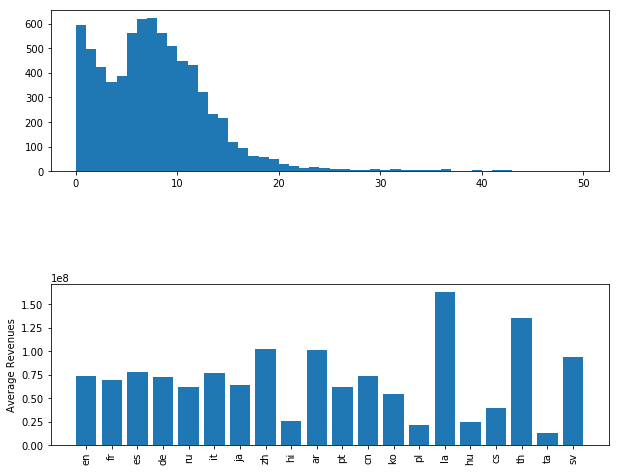

In [8]:
# Popularity and spoken_languages:

# plt.scatter(x=data[data['is_train']]['popularity'], y = data[data['is_train']]['revenue'])
popularity_fig = plt.figure(1, figsize=(10, 8))
popularity_fig.subplots_adjust(hspace=0.7, wspace=0.4)

popularity_hist = popularity_fig.add_subplot(211)

popularity_hist.hist(x=data[data['is_train'] & data['popularity'] < 50]['popularity'], bins=50, range=[0, 50])

## TODO: Popularity vs. Revenue

# average revenues for top 20 languages:
revenue_averages_by_popularity = []
for language_name in top_20_languages:
    revenue = data[data[language_name] == 1 & data['is_train']]['revenue'].dropna().values.mean()
#     print(revenue)
    revenue_averages_by_popularity.append(revenue)
    
language_barplot = popularity_fig.add_subplot(212)
language_barplot.bar(top_20_languages, revenue_averages_by_popularity)
language_barplot.tick_params(axis='x', labelrotation=90)
language_barplot.set_ylabel('Average Revenues')

[120334673.54950495, 109670828.09574468, 124783063.90062112, 113961915.66666667, 120284417.32967032, 68721455.66666667, 145159176.37333333, 76546547.3015873, 303777082.5483871, 75911345.01639344, 44320248.60869565, 78391981.6981132, 111337606.1875, 62731346.13636363, 51829712.675, 139645381.44444445, 105011750.41935484, 187110073.44444445, 47225870.862068966, 72128865.75]


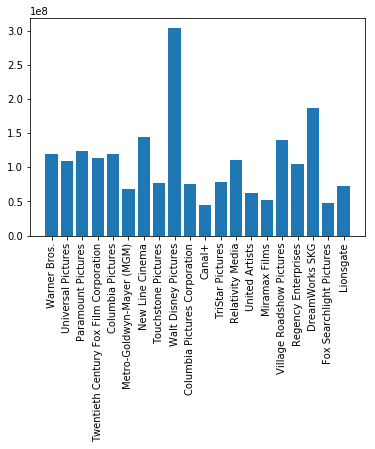

In [9]:
# Production companies:
company_freq = get_freqs(data['production_companies'], 'name')
# print(company_freq)

sorted_companies = sorted([(value, key) for (key, value) in company_freq.items()], reverse=True)
top_10_companies = [i[1] for i in sorted_companies[0:20]]
# print(top_10_companies)

# One-Hot Encoding:
for company in top_10_companies:
    data[company] = np.where(check_values(data['production_companies'], 'name', company), 1, 0)

average_revenues_by_company = []
for company in top_10_companies:
    revenue = data[data[company] == 1 & data['is_train']]['revenue'].dropna().values.mean()
    average_revenues_by_company.append(revenue)

print(average_revenues_by_company)

plt.bar(top_10_companies, average_revenues_by_company)
plt.tick_params(axis='x', labelrotation=90)


month_released
1     3.070678e+07
2     5.778889e+07
3     7.224145e+07
4     5.831416e+07
5     9.048772e+07
6     1.278864e+08
7     9.404021e+07
8     4.151070e+07
9     3.582428e+07
10    4.204264e+07
11    7.702461e+07
12    9.646238e+07
Name: revenue, dtype: float64


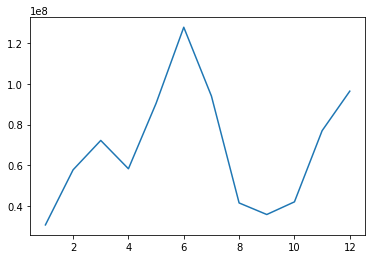

In [10]:
# release_data: group by months

from dateutil import parser

## there is one instance in the dataset that has release_date == NaN
data = data.drop(data[data['release_date'].isnull()].index)

parsed_months = []
for i in range(len(data['release_date'].values)):
    parsed_months.append(parser.parse(data['release_date'].values[i]).month)

data['month_released'] = pd.Series(parsed_months, index = data.index)

revenue_by_month = data.groupby('month_released')['revenue'].mean()
print(revenue_by_month)

plt.plot(revenue_by_month.index, revenue_by_month.values)

# 

##### It can be seen that average revenues are highest between 5-7, 11-12

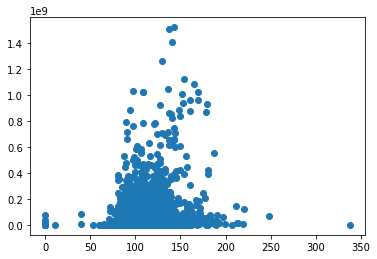

In [11]:
## Runtime:
data['runtime']
plt.scatter(data['runtime'], data['revenue'])


##### Movies run for 90 - 130 mins are most profitable. 

In [18]:
# Cast:
pd.set_option('display.max_columns', None)
data.head()
# data['cast'].head()[1]
data['crew'].head()[1]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36